<a href="https://colab.research.google.com/github/SofiMich/DL/blob/main/Tarea2/T2_1_Michaelian_convolucion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Convolución
En este primer ejercicio de la tarea adaptaré el notebook proporcionado para hacer la convolución sobre una imagen con tres canales aplicando el mismo filtro a cada canal.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits

## Carga conjunto de datos de dígitos 
Usaré el mismo conjunto de dígitos de `scikit-learn`, concatenando 3 arreglos iguales al dataset original por simplicidad:

In [ ]:
digits = load_digits() 
zeros_ones = digits.target < 2
data = digits.images[zeros_ones]
labels = digits.target[zeros_ones]

Además de concatenar tres veces el dataset, vamos a trasponerlo para que la forma de nuestro quede como: [N, H, W, C], en donde N son los ejemplos, H y W el alto y ancho respectivamente, y C el número de canales:

In [ ]:
data3d = np.stack((data, data, data)).transpose((1,2,3,0))
print(data3d.shape)

(360, 8, 8, 3)


Además, para que al graficarlas se vea que sí son tres canales, voy a sumarle algo de ruido aleatorio a cada imagen y a cada canal:

In [ ]:
ruido = np.random.randint(0,data3d.max()*0.3,data3d.shape)
data3d = data3d + ruido

Finalmente normalizamos los datos:

In [ ]:
data3d = data3d / data3d.max()

Visualicemos 2 instancias de los dígitos $0$ y $1$ de nuestro dataset de *juguete*:

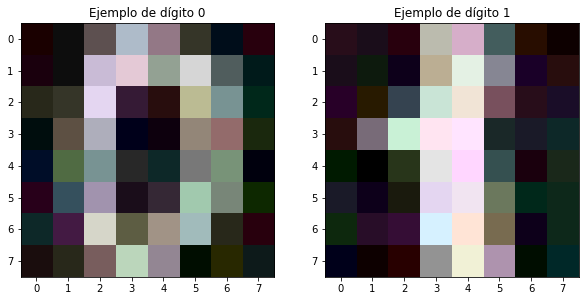

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(data3d[0]) 
axs[0].set_title('Ejemplo de dígito 0')
axs[1].imshow(data3d[1]) 
axs[1].set_title('Ejemplo de dígito 1')
plt.show() 

Como podemos ver, los dígitos siguen siendo legibles (dentro de lo que cabe) y son a color :B

In [ ]:
digits.target

array([0, 1, 2, ..., 8, 9, 8])

## Convolución 
La convolución entre una imagen $I$ y un filtro $W$ está definida por:

$$
A_{i,j} = (\mathbf{I} * \mathbf{W})_{i,j} = \sum_m \sum_n I_{m, n} W_{i - m, j - n},
$$

o, equivalentemente:

$$
A_{i,j} = (\mathbf{W} * \mathbf{I})_{i,j} = \sum_m \sum_n I_{i - m, j - n} W_{m,n},
$$

ya que es conmutativa.

Partiendo de la convolución definida en el notebook original, definiré una nueva con un ciclo anidado más que barre cada canal, aplicando así el mismo filtro por canal:

In [ ]:
from scipy.special import keip
def conv2d3c(I, W, b, stride = 1):
  h_s = int(np.floor((I.shape[0] - W.shape[0]) / stride)) + 1
  w_s = int(np.floor((I.shape[1] - W.shape[1]) / stride)) + 1

  a = np.zeros((h_s, w_s))
  for i in range(h_s):
      for j in range(w_s):
        I_m = I[ i * stride:i * stride + W.shape[0], j * stride:j * stride + W.shape[1]]

        a[i, j] = (I_m * W).sum() + b
                  
  return a

## Filtro

Usaré el mismo filtro de $3 \times 3$ que ya teníamos para la version BN para definir un filtro de $3\times 3 \times 3$:

(3, 3, 3)


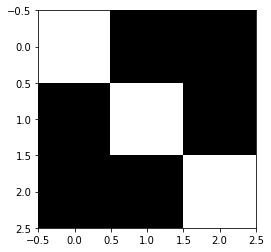

In [ ]:
filter = np.zeros((3,3))
np.fill_diagonal(filter, np.array([1, 1, 1]))
filter1 = np.stack((filter, filter, filter)).transpose((1,2,0))
print(filter1.shape) #para checar las dimensiones
plt.imshow(filter1)

Aplicando la convolución entre una imagen del dígito $0$ y el filtro que acabamos de definir se obtiene:

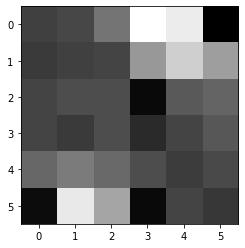

In [ ]:
a = conv2d3c(data3d[0], filter1, 0)
plt.imshow(a/a.max(), cmap = 'gray') 
plt.show()

Y al dígito 1:

(6, 6)


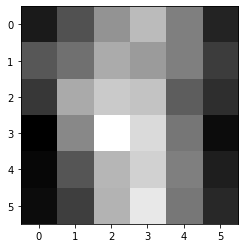

In [ ]:
a = conv2d3c(data3d[1], filter1, 0)
print(a.shape) #sólo para checar...
plt.imshow(a/a.max(), cmap = 'gray') 
plt.show()

Usaré los mismos filtros de $3\times 3$ del notebook original, solo que les agregamos una coordenada para los canales:

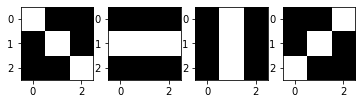

In [ ]:
filters = np.zeros((4, 3, 3, 3))
filters[0, :, :, :] = filter1
filters[1, 1, :, :] = 1
filters[2, :, 1, :] = 1
filters[3, :, :, :] = filter1[::-1]

b = np.zeros(4)

plt.subplot(1,4,1)
plt.imshow(filters[0]) 
plt.subplot(1,4,2)
plt.imshow(filters[1]) 
plt.subplot(1,4,3)
plt.imshow(filters[2]) 
plt.subplot(1,4,4)
plt.imshow(filters[3]) 
plt.show()

Para aplicar la operación de convolución con cada uno de estos filtros definimos la siguiente función que usa nuestra función de convolución en 3 canales definida previamente:

In [ ]:
def multi_conv2d3c(I, W, b, stride = 1):
  k = W.shape[0]
  
  activations = []
  for i in range(k):
    activations.append(conv2d3c(I, W[i], b[i], stride = 1)) 
                       
  return np.array(activations)

Al evaluar esta función con cuatro distintos filtros para nuestras dos imágenes, obtenemos los siguientes mapas de activaciones que también tienen tres canales cada uno:

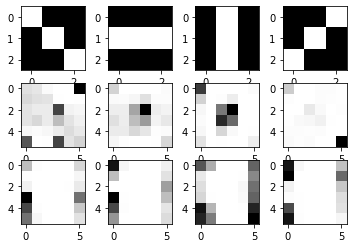

In [ ]:
activations_0 = np.tanh(multi_conv2d3c(data3d[0], filters, b))
activations_1 = np.tanh(multi_conv2d3c(data3d[1], filters, b))

for i in range(4):
  plt.subplot(3,4,i + 1)
  plt.imshow(filters[i])
  plt.subplot(3,4,i + 5)
  plt.imshow(activations_0[i], cmap = 'gray')
  plt.subplot(3,4,i + 9)
  plt.imshow(activations_1[i], cmap = 'gray')

Solo para ver qué pasa, vamos a aplicar el max pooling sobre las activaciones (usando exactamente las mismas funciones que en el notebook original:

In [ ]:
def submuestreo_maximo(activations, block = (2,2)):
  H, W = activations.shape
  H_s = H // block[0]
  W_s = W // block[1]

  sub_a = np.zeros((H_s,W_s))
  max_x = activations.reshape((H * W_s, block[1])).max(axis = 1)
  sub_a = max_x.T.reshape((W_s, block[0], H_s)).max(axis = 1)
  
  return sub_a

def multi_submuestreo_maximo(activations, block = (2,2)):
  k = activations.shape[0]
  sub_a = []
  for i in range(k):
    sub_a.append(submuestreo_maximo(activations[i]))
                       
  return np.array(sub_a)

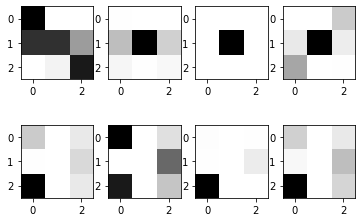

In [ ]:
sub_a0 = multi_submuestreo_maximo(activations_0)
sub_a1 = multi_submuestreo_maximo(activations_1)
for i in range(4):  

  plt.subplot(2,4,i + 1)
  plt.imshow(sub_a0[i], cmap = 'gray')
  plt.subplot(2,4,i + 5)
  plt.imshow(sub_a1[i], cmap = 'gray')